# Project 4: West Nile Virus Classification
---
   Leonard | Melvin | Pallavi
    
---

## Notebook 02: Modeling and Cost Benefit Analysis

### Contents:
- [Pre-Processing](#Pre-Processing)
- [One-Hot-Encoding](#One-Hot-Encoding)
- [Modeling](#Modeling)
    - [Hyperparameter Tuning](#Hyperparameter-Tuning)
        - [Logistic Regression](#Logistic-Regression)
        - [K-nearest Neighbors](#K-nearest-Neighbors)
        - [Random Forest](#Random-Forest)
        - [Support Vector Classification](#Support-Vector-Classification)
        - [XGBoost](#XGBoost)
    - [Learning Algorithm Selection](#Learning-Algorithm-Selection)
- [Final Model](#Final-Model)
- [Kaggle Submission](#Kaggle-Submission)
- [Cost-Benefit Analysis of Spray operations](#Cost-Benefit-Analysis-of-Spray-operations)
    - [Cost of spraying operations](#Cost-of-spraying-operations)
    - [Benefits of spraying operations](#Benefits-of-spraying-operations)
- [Summary and Recommendations](#Summary-and-Recommendations)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

import xgboost as xgb
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

In [3]:
df_train = pd.read_csv('../assets/processed_train.csv')
df_prediction = pd.read_csv('../assets/processed_test.csv')

In [4]:
df_train.drop(columns='Unnamed: 0', inplace = True, axis = 1)
df_prediction.drop(columns='Unnamed: 0', inplace = True, axis = 1)

### Pre-Processing

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             16950 non-null  object 
 1   Species          16950 non-null  object 
 2   Trap             16950 non-null  object 
 3   Latitude         16950 non-null  float64
 4   Longitude        16950 non-null  float64
 5   NumMosquitos     16950 non-null  int64  
 6   WnvPresent       16950 non-null  int64  
 7   Nearest_Station  16950 non-null  int64  
 8   Station          16950 non-null  int64  
 9   Tavg             16950 non-null  float64
 10  DewPoint         16950 non-null  int64  
 11  WetBulb          16950 non-null  float64
 12  PrecipTotal      16950 non-null  float64
 13  StnPressure      16950 non-null  float64
 14  AvgSpeed         16950 non-null  float64
 15  Year             16950 non-null  float64
 16  Month            16950 non-null  float64
 17  WeekofYear  

In [6]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232586 entries, 0 to 232585
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           232586 non-null  int64  
 1   Date         232586 non-null  object 
 2   Species      232586 non-null  object 
 3   Trap         232586 non-null  object 
 4   Latitude     232586 non-null  float64
 5   Longitude    232586 non-null  float64
 6   Station      232586 non-null  int64  
 7   Tavg         232586 non-null  float64
 8   DewPoint     232586 non-null  int64  
 9   WetBulb      232586 non-null  float64
 10  PrecipTotal  232586 non-null  float64
 11  StnPressure  232586 non-null  float64
 12  AvgSpeed     232586 non-null  float64
 13  Year         232586 non-null  float64
 14  Month        232586 non-null  float64
 15  WeekofYear   232586 non-null  float64
dtypes: float64(10), int64(3), object(3)
memory usage: 28.4+ MB


In [7]:
# we only need a single station for evaluation hence we drop station 2 from rows and then we drop the station columns
df_train = df_train[df_train['Station'] != 2]
df_prediction = df_prediction[df_prediction['Station'] != 2]

In [8]:
# during the EDA portion the date has already been sprase out into 3 new columns 'Year', 'Month' & 'WeekofYear'
# Since the test set does not have NumMosquitos this is also drop on the train set
# Nearest_Station is also dropped as it was only use for EDA purpose
df_train.drop(columns=['Date', 'NumMosquitos', 'Nearest_Station', 'Station'], inplace = True, axis = 1)

In [9]:
# date is also drop from the prediction set, and Id column is dropped since it is only used for kaggle score
df_prediction.drop(columns=['Date', 'Id', 'Station'], inplace = True, axis = 1)

In [10]:
print(df_train.shape, df_prediction.shape)

(8475, 14) (116293, 13)


### One-Hot Encoding

Columns `Species` and `Trap` requires us to do do one-hot encoding however exploring the dataset, we can see that there is additional categorical information in `Species` and `Trap`, train set has `7 Species` category while prediction set has `8 Species` category. The same can be seen on `Trap` where train set has `136` vs `149` on the prediction set.  

Using a combined dataset I created the dummy variables and then split them back into the appropriate dataframes again `train` and `prediction`.

In [11]:
print(f"No. of unique species:\ntrain - {df_train['Species'].nunique()}\npredict - {df_prediction['Species'].nunique()}")

No. of unique species:
train - 7
predict - 8


In [12]:
print(f"No. of unique traps:\ntrain - {df_train['Trap'].nunique()}\npredict - {df_prediction['Trap'].nunique()}")

No. of unique traps:
train - 136
predict - 149


In [13]:
df_train_num = len(df_train)

# concat without the WnvPresent columns as that will be our target variable
df_combine = pd.concat(objs = [df_train.drop('WnvPresent', axis = 1), df_prediction], axis = 0)

# get dummy variables
df_combine = pd.get_dummies(df_combine)

# extract the train set out
df_train_final = df_combine[:df_train_num]

# extract the prediction set out
df_prediction_final = df_combine[df_train_num:]

In [14]:
# check to ensure that the shape row and columns are correct.
print(f"train - {df_train_final.shape}\npredict - {df_prediction_final.shape}")

train - (8475, 168)
predict - (116293, 168)


In [15]:
# adding the WnvPresent column back into the train set so that we can do a split later
df_wnv = pd.DataFrame(df_train['WnvPresent'])
df_train_final = pd.concat(objs = [df_train_final, df_wnv], axis = 1)

In [16]:
df_train_final.shape

(8475, 169)

## Modeling 

The classifier choosen are Logistic Regression, K Nearest Neighbor, Random Forest, Support Vector Classification and XGBoost.  

Below is a summary of the flow of modeling:  
- Hyperparameter tuning on all 5 classifiers
- Cross validation score on all 5 classifiers using only the best hyperparameter choosen
- Evaluate the best learning algorithm
- Train the entire train.csv with the best learning algorithm for production usage (in this case test.csv)

### Hyperparameter Tuning

In [18]:
# train-test split
X, y = df_train_final.drop(columns = 'WnvPresent'), df_train_final['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [19]:
# Initializing Classifiers
clf_lr  = LogisticRegression(solver='liblinear', random_state=0)
clf_knn = KNeighborsClassifier()
clf_rf  = RandomForestClassifier(random_state=0)
clf_svc = SVC(random_state=0)
clf_xgc = xgb.XGBClassifier(random_state=0)

# Building the model pipelines incl. preprocessing where needed 
# Note that the random forest and xgboost does not need feature scaling
pipe_lr  = Pipeline([('std', StandardScaler()),
                     ('clf_lr', clf_lr)])

pipe_svc = Pipeline([('std', StandardScaler()),
                     ('clf_svc', clf_svc)])

pipe_knn = Pipeline([('std', StandardScaler()),
                     ('clf_knn', clf_knn)])

# Setting up the parameter grids
param_grid_lr  = [{'clf_lr__penalty': ['l1', 'l2'],
                   'clf_lr__C': np.logspace(-4, 4, 9)}]

param_grid_knn = [{'clf_knn__n_neighbors': list(range(3, 7)),
                   'clf_knn__p': [1, 2],
                   'clf_knn__leaf_size': [5, 10, 15],
                   'clf_knn__weights': ['uniform', 'distance']}]

param_grid_rf  = [{'n_estimators': [10, 20, 50, 100, 150, 200],
                   'min_samples_leaf': [2, 5, 10],
                   'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'clf_svc__kernel': ['rbf'],
                   'clf_svc__C': np.logspace(-1, 3, 5),
                   'clf_svc__gamma': np.logspace(-4, 0, 4)[:3]}]

param_grid_xgc = [{'eval_metric' : ['auc'],
                   'subsample' : [0.5], 
                   'colsample_bytree' : [0.2], 
                   'learning_rate' : [0.1],
                   'max_depth' : [3], 
                   'reg_alpha' : [0, 1, 1.5],
                   'reg_lambda' : [1, 2, 5],
                   'gamma' : [0.01, 0.03, 0.05]}]

In [20]:
# Initialize functions for grid search, calling on above functions, and printing model metrics
def grid_search(classifier, params):
    gs = GridSearchCV(classifier, param_grid=params, cv=3, scoring='roc_auc', verbose=5)
    gs.fit(X_train, y_train)
    print(f'Train AUC Score: {round(gs.best_score_, 4)}')
    print(f'Using the following parameters: {gs.best_params_}')
    print('\n')
    return

In [21]:
def crossvalscore(classifer_best_params):
    model = classifer_best_params.fit(X_train, y_train)
    score = cross_val_score(classifer_best_params,
                            X=X_train,
                            y=y_train,
                            cv=5,
                            n_jobs=1,
                            scoring='roc_auc')
    print(score)
    print(f'AUC Mean Score {100*score.mean():.2f} +/- {100*score.std():.2f}')
    return

### Logistic Regression

In [157]:
grid_search(pipe_lr, param_grid_lr)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] clf_lr__C=0.0001, clf_lr__penalty=l1 ............................
[CV]  clf_lr__C=0.0001, clf_lr__penalty=l1, score=0.500, total=   0.1s
[CV] clf_lr__C=0.0001, clf_lr__penalty=l1 ............................
[CV]  clf_lr__C=0.0001, clf_lr__penalty=l1, score=0.500, total=   0.1s
[CV] clf_lr__C=0.0001, clf_lr__penalty=l1 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  clf_lr__C=0.0001, clf_lr__penalty=l1, score=0.500, total=   0.1s
[CV] clf_lr__C=0.0001, clf_lr__penalty=l2 ............................
[CV]  clf_lr__C=0.0001, clf_lr__penalty=l2, score=0.766, total=   0.1s
[CV] clf_lr__C=0.0001, clf_lr__penalty=l2 ............................
[CV]  clf_lr__C=0.0001, clf_lr__penalty=l2, score=0.752, total=   0.1s
[CV] clf_lr__C=0.0001, clf_lr__penalty=l2 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV]  clf_lr__C=0.0001, clf_lr__penalty=l2, score=0.749, total=   0.1s
[CV] clf_lr__C=0.001, clf_lr__penalty=l1 .............................
[CV] . clf_lr__C=0.001, clf_lr__penalty=l1, score=0.500, total=   0.1s
[CV] clf_lr__C=0.001, clf_lr__penalty=l1 .............................
[CV] . clf_lr__C=0.001, clf_lr__penalty=l1, score=0.500, total=   0.1s
[CV] clf_lr__C=0.001, clf_lr__penalty=l1 .............................
[CV] . clf_lr__C=0.001, clf_lr__penalty=l1, score=0.500, total=   0.1s
[CV] clf_lr__C=0.001, clf_lr__penalty=l2 .............................
[CV] . clf_lr__C=0.001, clf_lr__penalty=l2, score=0.760, total=   0.1s
[CV] clf_lr__C=0.001, clf_lr__penalty=l2 .............................
[CV] . clf_lr__C=0.001, clf_lr__penalty=l2, score=0.746, total=   0.1s
[CV] clf_lr__C=0.001, clf_lr__penalty=l2 .............................
[CV] . clf_lr__C=0.001, clf_lr__penalty=l2, score=0.748, total=   0.1s
[CV] clf_lr__C=0.01, clf_lr__penalty=l1 ..............................
[CV] .

C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf_lr__C=100.0, clf_lr__penalty=l1, score=0.739, total=   4.3s
[CV] clf_lr__C=100.0, clf_lr__penalty=l1 .............................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf_lr__C=100.0, clf_lr__penalty=l1, score=0.706, total=   2.8s
[CV] clf_lr__C=100.0, clf_lr__penalty=l1 .............................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf_lr__C=100.0, clf_lr__penalty=l1, score=0.749, total=  15.7s
[CV] clf_lr__C=100.0, clf_lr__penalty=l2 .............................
[CV] . clf_lr__C=100.0, clf_lr__penalty=l2, score=0.740, total=   0.7s
[CV] clf_lr__C=100.0, clf_lr__penalty=l2 .............................
[CV] . clf_lr__C=100.0, clf_lr__penalty=l2, score=0.705, total=   0.6s
[CV] clf_lr__C=100.0, clf_lr__penalty=l2 .............................
[CV] . clf_lr__C=100.0, clf_lr__penalty=l2, score=0.749, total=   0.7s
[CV] clf_lr__C=1000.0, clf_lr__penalty=l1 ............................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf_lr__C=1000.0, clf_lr__penalty=l1, score=0.739, total=   5.3s
[CV] clf_lr__C=1000.0, clf_lr__penalty=l1 ............................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf_lr__C=1000.0, clf_lr__penalty=l1, score=0.707, total=   4.5s
[CV] clf_lr__C=1000.0, clf_lr__penalty=l1 ............................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf_lr__C=1000.0, clf_lr__penalty=l1, score=0.748, total=   2.2s
[CV] clf_lr__C=1000.0, clf_lr__penalty=l2 ............................
[CV]  clf_lr__C=1000.0, clf_lr__penalty=l2, score=0.739, total=   0.9s
[CV] clf_lr__C=1000.0, clf_lr__penalty=l2 ............................
[CV]  clf_lr__C=1000.0, clf_lr__penalty=l2, score=0.700, total=   1.0s
[CV] clf_lr__C=1000.0, clf_lr__penalty=l2 ............................
[CV]  clf_lr__C=1000.0, clf_lr__penalty=l2, score=0.750, total=   0.8s
[CV] clf_lr__C=10000.0, clf_lr__penalty=l1 ...........................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf_lr__C=10000.0, clf_lr__penalty=l1, score=0.739, total=   5.1s
[CV] clf_lr__C=10000.0, clf_lr__penalty=l1 ...........................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf_lr__C=10000.0, clf_lr__penalty=l1, score=0.708, total=   5.7s
[CV] clf_lr__C=10000.0, clf_lr__penalty=l1 ...........................


C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf_lr__C=10000.0, clf_lr__penalty=l1, score=0.748, total=  12.9s
[CV] clf_lr__C=10000.0, clf_lr__penalty=l2 ...........................
[CV]  clf_lr__C=10000.0, clf_lr__penalty=l2, score=0.739, total=   1.1s
[CV] clf_lr__C=10000.0, clf_lr__penalty=l2 ...........................
[CV]  clf_lr__C=10000.0, clf_lr__penalty=l2, score=0.695, total=   1.0s
[CV] clf_lr__C=10000.0, clf_lr__penalty=l2 ...........................
[CV]  clf_lr__C=10000.0, clf_lr__penalty=l2, score=0.750, total=   1.2s


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.5min finished


Train AUC Score: 0.763
Using the following parameters: {'clf_lr__C': 0.1, 'clf_lr__penalty': 'l1'}




In [162]:
clf_lr_best = LogisticRegression(solver='liblinear', random_state=0, C=0.1, penalty='l1')

In [163]:
crossvalscore(clf_lr_best)

C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Melvin\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.73402449 0.73619193 0.68418411 0.72589927 0.70871105]
AUC Mean Score 71.78 +/- 1.94


### K-nearest Neighbors

In [159]:
grid_search(pipe_knn, param_grid_knn)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=uniform, score=0.674, total=   2.0s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=uniform, score=0.620, total=   1.9s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=uniform, score=0.642, total=   1.9s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=distance 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=distance, score=0.673, total=   1.9s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=distance 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=distance, score=0.622, total=   2.0s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=1, clf_knn__weights=distance, score=0.640, total=   1.9s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=2, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=2, clf_knn__weights=uniform, score=0.640, total=   2.1s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=2, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=2, clf_knn__weights=uniform, score=0.585, total=   2.2s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=2, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=3, clf_knn__p=2, clf_knn__weights=uniform, score=0.625, total=   2.1s
[CV] clf_knn__leaf_size=5, clf_knn__n_

[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=uniform, score=0.638, total=   2.7s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=uniform, score=0.652, total=   2.7s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=distance, score=0.670, total=   2.6s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=distance, score=0.638, total=   2.7s
[CV] clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=5, clf_knn__n_neighbors=6, clf_knn__p=2, clf_knn__weights=distance, score=0.654, total=   2.5s
[CV] clf_knn__leaf_size=10, clf_knn

[CV]  clf_knn__leaf_size=10, clf_knn__n_neighbors=5, clf_knn__p=2, clf_knn__weights=distance, score=0.620, total=   2.0s
[CV] clf_knn__leaf_size=10, clf_knn__n_neighbors=5, clf_knn__p=2, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=10, clf_knn__n_neighbors=5, clf_knn__p=2, clf_knn__weights=distance, score=0.648, total=   2.1s
[CV] clf_knn__leaf_size=10, clf_knn__n_neighbors=6, clf_knn__p=1, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=10, clf_knn__n_neighbors=6, clf_knn__p=1, clf_knn__weights=uniform, score=0.694, total=   2.2s
[CV] clf_knn__leaf_size=10, clf_knn__n_neighbors=6, clf_knn__p=1, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=10, clf_knn__n_neighbors=6, clf_knn__p=1, clf_knn__weights=uniform, score=0.669, total=   2.3s
[CV] clf_knn__leaf_size=10, clf_knn__n_neighbors=6, clf_knn__p=1, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=10, clf_knn__n_neighbors=6, clf_knn__p=1, clf_knn__weights=uniform, score=0.665, total=   2.3s
[CV] clf_knn__leaf_size=10, c

[CV]  clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=uniform, score=0.662, total=   2.4s
[CV] clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=uniform 
[CV]  clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=uniform, score=0.656, total=   2.0s
[CV] clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=distance, score=0.693, total=   2.1s
[CV] clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=distance, score=0.664, total=   2.2s
[CV] clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=distance 
[CV]  clf_knn__leaf_size=15, clf_knn__n_neighbors=5, clf_knn__p=1, clf_knn__weights=distance, score=0.657, total=   2.0s
[CV] clf_knn__leaf_size=15

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  5.0min finished


Train AUC Score: 0.68
Using the following parameters: {'clf_knn__leaf_size': 5, 'clf_knn__n_neighbors': 6, 'clf_knn__p': 1, 'clf_knn__weights': 'distance'}




In [164]:
clf_knn_best = KNeighborsClassifier(n_neighbors=6, leaf_size=5, p=1, weights='distance')

In [165]:
crossvalscore(clf_knn_best)

[0.7882211  0.73408856 0.75576827 0.70750275 0.68871485]
AUC Mean Score 73.49 +/- 3.51


### Random Forest

In [158]:
grid_search(clf_rf, param_grid_rf)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=10 ..........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=10, score=0.840, total=   0.1s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=10, score=0.819, total=   0.1s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=10 ..........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=10, score=0.800, total=   0.1s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=20 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=20, score=0.840, total=   0.1s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=20 ..........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=20, score=0.824, total=   0.1s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=20 ..........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=20, score=0.813, total=   0.2s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=50 ..........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=50, score=0.857, total=   0.4s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=50 ..........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=50, score=0.836, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=50 ..........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=50, score=0.818, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=100 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=100, score=0.859, total=   0.6s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=100 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=100, score=0.841, total=   0.6s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=100 .........
[CV]  max_features=sqrt, min_samples_l

[CV]  max_features=log2, min_samples_leaf=2, n_estimators=20, score=0.849, total=   0.1s
[CV] max_features=log2, min_samples_leaf=2, n_estimators=20 ..........
[CV]  max_features=log2, min_samples_leaf=2, n_estimators=20, score=0.816, total=   0.1s
[CV] max_features=log2, min_samples_leaf=2, n_estimators=20 ..........
[CV]  max_features=log2, min_samples_leaf=2, n_estimators=20, score=0.819, total=   0.1s
[CV] max_features=log2, min_samples_leaf=2, n_estimators=50 ..........
[CV]  max_features=log2, min_samples_leaf=2, n_estimators=50, score=0.856, total=   0.3s
[CV] max_features=log2, min_samples_leaf=2, n_estimators=50 ..........
[CV]  max_features=log2, min_samples_leaf=2, n_estimators=50, score=0.834, total=   0.2s
[CV] max_features=log2, min_samples_leaf=2, n_estimators=50 ..........
[CV]  max_features=log2, min_samples_leaf=2, n_estimators=50, score=0.819, total=   0.3s
[CV] max_features=log2, min_samples_leaf=2, n_estimators=100 .........
[CV]  max_features=log2, min_samples_lea

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   44.7s finished


Train AUC Score: 0.8439
Using the following parameters: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}




In [194]:
clf_rf_best = RandomForestClassifier(max_features='sqrt', min_samples_leaf=5, n_estimators=200, random_state = 0)

In [193]:
crossvalscore(clf_rf_best)

[0.87240949 0.84320781 0.8360542  0.83829637 0.8340958 ]
AUC Mean Score 84.48 +/- 1.41


### Support Vector Classification

In [202]:
grid_search(pipe_svc, param_grid_svc)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] clf_svc__C=0.1, clf_svc__gamma=0.0001, clf_svc__kernel=rbf ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf_svc__C=0.1, clf_svc__gamma=0.0001, clf_svc__kernel=rbf, score=0.598, total=   0.8s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.0001, clf_svc__kernel=rbf ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  clf_svc__C=0.1, clf_svc__gamma=0.0001, clf_svc__kernel=rbf, score=0.635, total=   0.8s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.0001, clf_svc__kernel=rbf ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  clf_svc__C=0.1, clf_svc__gamma=0.0001, clf_svc__kernel=rbf, score=0.680, total=   0.8s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.002154434690031882, clf_svc__kernel=rbf 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s


[CV]  clf_svc__C=0.1, clf_svc__gamma=0.002154434690031882, clf_svc__kernel=rbf, score=0.757, total=   1.2s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.002154434690031882, clf_svc__kernel=rbf 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  clf_svc__C=0.1, clf_svc__gamma=0.002154434690031882, clf_svc__kernel=rbf, score=0.742, total=   1.2s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.002154434690031882, clf_svc__kernel=rbf 
[CV]  clf_svc__C=0.1, clf_svc__gamma=0.002154434690031882, clf_svc__kernel=rbf, score=0.748, total=   1.2s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.046415888336127774, clf_svc__kernel=rbf 
[CV]  clf_svc__C=0.1, clf_svc__gamma=0.046415888336127774, clf_svc__kernel=rbf, score=0.712, total=   1.5s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.046415888336127774, clf_svc__kernel=rbf 
[CV]  clf_svc__C=0.1, clf_svc__gamma=0.046415888336127774, clf_svc__kernel=rbf, score=0.682, total=   1.5s
[CV] clf_svc__C=0.1, clf_svc__gamma=0.046415888336127774, clf_svc__kernel=rbf 
[CV]  clf_svc__C=0.1, clf_svc__gamma=0.046415888336127774, clf_svc__kernel=rbf, score=0.686, total=   1.5s
[CV] clf_svc__C=1.0, clf_svc__gamma=0.0001, clf_svc__kernel=rbf ......
[CV]  clf_svc__C=1.0, clf_svc__gamma=0.0001, clf_svc__kernel=rbf, score=0.541,

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.1min finished


Train AUC Score: 0.7672
Using the following parameters: {'clf_svc__C': 100.0, 'clf_svc__gamma': 0.0001, 'clf_svc__kernel': 'rbf'}




In [155]:
clf_svc_best = SVC(random_state=0, C=100, gamma=0.0001, kernel='rbf')

In [156]:
crossvalscore(clf_svc_best)

[0.82861231 0.81316264 0.79975229 0.80939365 0.75870683]
AUC Mean Score 80.19 +/- 2.35


### XGBoost

In [286]:
grid_search(clf_xgc, param_grid_xgc)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=1, subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=1, subsample=0.5, score=0.859, total=   0.6s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=1, subsample=0.5, score=0.835, total=   0.6s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=1, subsample=0.5, score=0.842, total=   0.6s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=2, subsample=0.5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=2, subsample=0.5, score=0.858, total=   0.6s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=2, subsample=0.5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s


[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=2, subsample=0.5, score=0.833, total=   0.5s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=2, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=2, subsample=0.5, score=0.838, total=   0.6s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5, score=0.855, total=   0.6s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.01, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5, score

[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5, score=0.854, total=   0.9s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5, score=0.829, total=   0.5s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5, score=0.835, total=   0.4s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.03, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5, score

[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=5, subsample=0.5, score=0.835, total=   0.5s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5, score=0.858, total=   0.5s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5, score=0.832, total=   0.5s
[CV] colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5 
[CV]  colsample_bytree=0.2, eval_metric=auc, gamma=0.05, learning_rate=0.1, max_depth=3, reg_alpha=1, reg_lambda=1, subsample=0.5, score

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   44.3s finished


Train AUC Score: 0.8453
Using the following parameters: {'colsample_bytree': 0.2, 'eval_metric': 'auc', 'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.5}




In [288]:
clf_xgc_best = xgb.XGBClassifier(random_state = 0,
                                 colsample_bytree=0.2,
                                 eval_metric='auc',
                                 gamma=0.03,
                                 learning_rate=0.1,
                                 max_depth=3,
                                 reg_alpha=0,
                                 reg_lambda=1,
                                 subsample=0.5)

In [289]:
crossvalscore(clf_xgc_best)

[0.8707065  0.8336572  0.8345167  0.83932137 0.84443121]
AUC Mean Score 84.45 +/- 1.36


### Learning Algorithm Selection

- Logistic Regression ROC_AUC Mean Score(std): `71.78 +/- 1.94`
- K Nearest Neighbor ROC_AUC Mean Score(std): `73.49 +/- 3.51`
- Random Forest ROC_AUC Mean Score(std): `84.48 +/- 1.41`
- Support Vector Classification ROC_AUC Mean Score(std): `80.19 +/- 2.35`
- XGBoost ROC_AUC Mean Score(std): `84.45 +/- 1.36`

Using `GridSearchCV` followed by `cross_val_score` we were able to tune the respective classifier with the optimised hyperparameters and then check if the learning algorithm is capable of yielding high mean score and low variances as we would want the selected learning algorithm to be capable of producing similar performance on unseen data. In this case it will be the test set provided by kaggle. 

By comparing the above scores, the final learning algorithm that is choosen is XGBoost. Using the best parameters selected are `colsample_bytree = 0.2`, `gamma = 0.03`, `learning_rate = 0.1`, `max_depth = 3`, `reg_alpha = 0`, `reg_lambda = 1`, `subsample = 0.5`.

In [22]:
# using the selected learning algorithm with best parameters
best_algo = xgb.XGBClassifier(random_state = 0,
                              colsample_bytree=0.2,
                              eval_metric='auc',
                              gamma=0.03,
                              learning_rate=0.1,
                              max_depth=3,
                              reg_alpha=0,
                              reg_lambda=1,
                              subsample=0.5)

# fit it and get the train & test roc_auc_score
best_algo.fit(X_train, y_train)
train_auc = roc_auc_score(y_true=y_train, y_score=best_algo.predict_proba(X_train)[:,1])
test_auc = roc_auc_score(y_true=y_test, y_score=best_algo.predict_proba(X_test)[:,1])

# print out the scores
print(f'Training ROC AUC: {100*train_auc:.2f}')
print(f'Test ROC AUC: {100*test_auc:.2f}')

Training ROC AUC: 88.70
Test ROC AUC: 85.11


In [28]:
features = pd.DataFrame(list(zip(X_train.columns, best_algo.feature_importances_))
                        , columns=['feature','importance']) 

In [33]:
features_10 = features.sort_values('importance', axis=0, ascending=False)[:10]

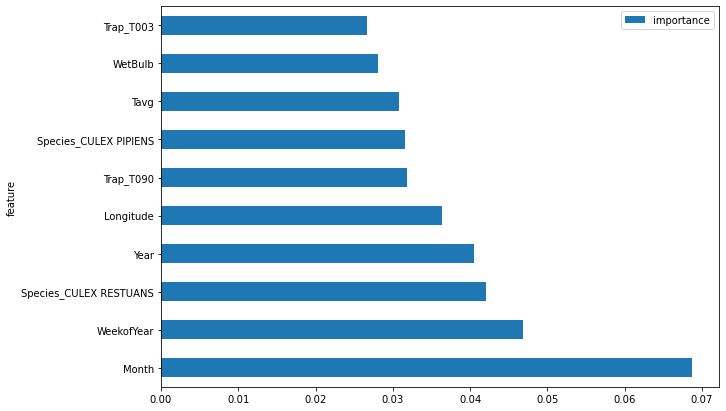

In [63]:
features_10.plot(kind='barh', x='feature', y='importance', figsize = (10, 7));

In [23]:
# sort the predict probability and the actual values in to a dataframe
pred_proba = [i[1] for i in best_algo.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
3188,1,0.232798
6312,0,0.008018
10894,0,0.022125
13920,0,0.018032
5454,0,0.018582


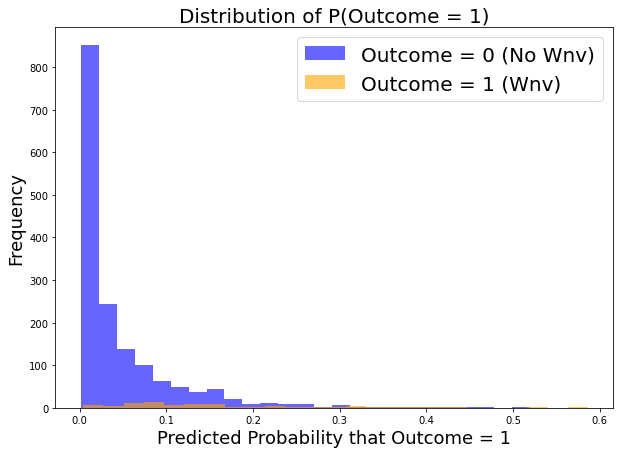

In [260]:
# Create figure for distribution graph
plt.figure(figsize = (10, 7))

# Creating two histograms of observations, with blue (WnvPresent = 0) 
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0 (No Wnv)')

# Yellow (WnvPresent = 1)
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1 (Wnv)')

# Labeling of axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Creating of legends
plt.legend(fontsize=20);

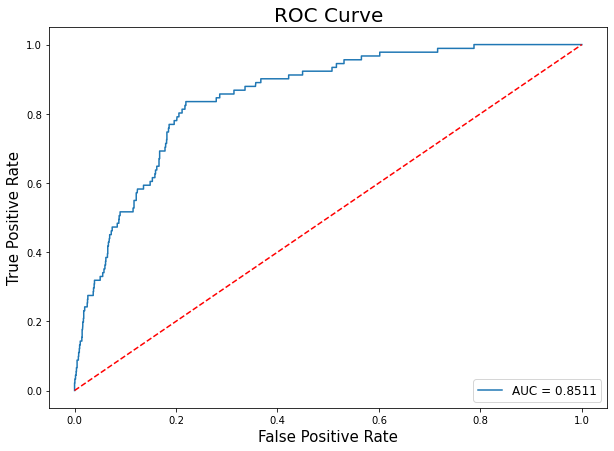

In [294]:
# with reference to https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, threshold = roc_curve(pred_df['true_values'], pred_df['pred_probs'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('ROC Curve', fontsize = 20)
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 'large')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.show()

Our final choosen model achieves an ROC_AUC_Score of `0.8511` based on our test data. This score, unsurprisingly, does not outperform the baseline score of 0.948, which is artificially high due to the disproportionate presence of `WnvPresent=1` data. As mentioned in the beginning of the project, merely achieving a high score to beat the baseline score is not the sole objective of this project. The model is expected to improve if more data is added to our training set.

We then plotted the top 10 most importance features in our model, the distribution of predicted probability as well as the ROC Curve to visualise the results of the model. 

The top 10 features are as we expected as during our EDA we were able to observe that West Nile Virus are more favourable in hot and dry conditions. Hence, features that embodies seasonlity like weather, year/month, as well as species and trap would help to predict and inform if West Nile Virus is present or absent.

The distribution plot shows us the predicted probability distribution for both classes `1` and `0`. The model is likely to accurately predict class `0` as the distribution is skewed highly towards the right. Given that most predictions should be class `0`, this is unsurprising. 

The ROC Curve allows us to summarize the trade-off between the true positive rate and false positive rate for a predictive model using different classification thresholds. The curve looks indicative of our score of 0.8511 which as mentioned, is unlikely to beat the baseline score of normalised counts.

### Final Model  

We now proceed to train the entire train.csv with our choosen learning algorithm and roll it out for production (in this case testing on unseen data on test.csv)

In [299]:
# combine both train test split to do a final train and then evaluate against kaggle and check score!
# final model for kaggle prediction
X_final, y_final = df_train_final.drop(columns='WnvPresent', axis=1), df_train_final['WnvPresent']

In [300]:
best_algo.fit(X_final, y_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, eval_metric='auc',
              gamma=0.03, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [301]:
final_auc = roc_auc_score(y_true=y_final, y_score=best_algo.predict_proba(X_final)[:,1])

In [302]:
final_auc

0.8834014332085411

### Kaggle Submission

In [304]:
# kaggle (test.csv) predictions using our final production model
kaggle_preds = best_algo.predict_proba(df_prediction_final)[:,1]

# we read in the processed_test.csv since we need the Id columns as this was dropped at the start of the notebook
processed_test = pd.read_csv('../assets/processed_test.csv')
processed_test = processed_test[processed_test['Station'] != 2] # remove 'Station' = 2

# output file inline with kaggle submissions format
output_file = pd.DataFrame({'Id': processed_test.Id, 'WnvPresent': kaggle_preds})

# save the csv
output_file.to_csv('../assets/kaggle_submissions_xgboost.csv', index=False)

<img src="../assets/kaggle_score.jpg"/>

## Cost-Benefit Analysis of Spray operations

### Cost of spraying operations

The city of Chicago started <a href = "https://chicago.cbslocal.com/2017/08/30/spray-mosquitoes-far-south-side-west-nile-prevention/"> spraying operations </a> for the first time in the first week of September 2017 in areas of the Pullman and South Deering neighborhoods. The operation starts at dusk (around 6.49 pm according to the weather dataset) and lasts till 1 a.m, making it an average of about 5 hours of spraying. The spraying is done by licensed mosquito abatement technicians in trucks dispensing an ultra-low-volume spray. The main chemical used is <a href = "https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox">Zenivex™ E4 </a>, which is  4% solution of a chemical known as Etofenprox, a reduced risk synthetic pyrethroid with an extremely low toxicity to mammals. It is sprayed from a truck at 4.5-9.0 ounces per minute, at a vehicle speed of 10-15 mph (16 to 24 kmh). The cost of Zenivex™ E4 is about USD \$80 per gallon according to <a href = "http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf"> tender information in North Dakota </a>.

<img src="http://www.meepi.org/wnv/graphics/trucksprayjpg.jpg" alt="ULV Sprayer in the City of Chicago" width="400">

Assuming each truck travels at the lowest speed of 16 kmh, a single truck can spray approximately (16 km $\times$ 0.003 km $\times$ 5 hours) in a single night, covering 0.24 km<sup>2</sup>. If each truck were to spray an average of 6.75 ounces (0.05 gallon) per minute. Each truck would spray 3 gallons of Zenivex™ E4 per hour and hence 15 gallons a night. The total cost of Zenivex™ E4 for a truck for a night would hence be USD 80 per gallon $\times$ 15 gallons = **USD 1,200** covering **0.24 km<sup>2</sup>**. The cost to spray **1 km<sup>2</sup>** will be approximately **USD 5,000**.

If each truck were to travel at the highest speed of 24 kmh, a single truck can spray approximately (24 km $\times$ 0.003 km $\times$ 5 hours) in a single night, covering 0.36 km<sup>2</sup>. Assuming the cost for Zenivex™ E4 per truck for the entire night is the same as above, we would spend **USD 1,200** covering 0.36 km<sup>2</sup> per truck. The cost to spray **1 km<sup>2</sup>** will be approximately **USD 3,333**.

Considering the city of Chicago has a total areas of 606.1 km<sup>2</sup> of which an estimated 50 \% is built-up area that is driveable, it would cost between **USD 1.21 - USD 1.82 million** to cover the entire city assuming that we incure a fixed cost premium of 20 \% for the operation of trucks and fuel costs and worker salaries are with almost no wastage of chemicals. 




### Benefits of spraying operations

There are multiple benefits from a reduced mosquito population as a result of spraying. These include an increased quality of life from fewer people falling sick and dying, increased workplace productivity from fewer people falling ill and going on medical leave, as well as savings in hospital expenses from treating WNV patients. Of these, only the latter two are measurable.

About 1 in 5 people infected with WNV develop the highly incapacitative <a href = "https://www.uptodate.com/contents/west-nile-virus-infection-beyond-the-basics">West Nile fever </a> with other symptoms such as headache, body aches, joint pains, vomiting, etc. Recovery from West Nile fever takes from a few days to several weeks, and prolonged fatigue is common.

About 1 in 150 people infected develop severe neuroinvasive diseases such as encephalitis or meningitis, in which the virus travels through the blood and infects the brain and spinal cord. Recovery is prolonged and less than 40% of patients with the severe diseases recover after one year.

Given that the <a href="https://datausa.io/profile/geo/chicago-il/">median household income</a> in Chicago was \\$55,295 (as of 2017), one can estimate the amount of losses the city will face from a workforce affected by WNV. 

In 2017, there were <a href="https://chicago.cbslocal.com/2018/08/29/west-nile-virus-death-reported-in-illinois/"> 90 WNV cases, including 8 deaths </a>. This means that approximately 18 people developed West Nile fever. Assuming all were working adults and each took two weeks off work to recover, this would have resulted in a total income loss of \\$38,281 in total. On average, each WNV patient spends approximately \\$25,000 in the hospital. Therefore the total monetary loss caused by WNV in 2017 is approximately **\\$488,281**.

## Summary and Recommendations

---

Using XGBoost (our best performing model), we achieved an ROC_AUC of **0.8511**.

Examination of the the total costs of spraying the whole of Chicago compared against the benefits show that the costs far outweigh the benefits in monetary terms. At best, accounting for inflation or even a pessimistic outcome of having 50% more WNV infections, the total monetary benefit to Chicago as a society may only be 16%-25% of the total cost of spraying.

However, our model does not take into account any non-monetary benefits to reducing the mosquito population. These include the emotional costs from loss of life, the reduction in the need for enhanced testing for suspected WNV cases and public confidence in the government.

From previous geospatial analysis of spray data, there is a distinct lack of evidence to support the claim that mosquito spraying had any effect on the reduction of WNV-infected mosquitos. Furthermore, the spray data pointed towards highly fragmented and haphazardous spraying operations that did not seem to be driven by the evidence if the presence and severity of WNV mosquito infestations. Traps such as the T900 trap at O'Hare International airport which proved to capture the most WNV-infected mosquitos by far were not sprayed. 

Given the high costs required to conduct spraying operations, we hence recommend the following action points:

1. Re-examine the effectiveness of spraying Zenivex™ E4 as a means to control the mosquito population. Evidence points towards the ineffectiveness of the chemical and it is likely that other kinds of non-toxic mosquito sprays should be explored.


2. Re-direct mosquito spraying operations in a more organised and evidence-driven manner whereby severe hotspots such as O'Hare International Airport are sprayed first at the beginning of summer in order to prevent large populations of mosquitos forming. In addition, spraying operations should be accurately logged and routes planned to make sure mosquito breeding sites are properly covered.


3. Examine new ways of controlling the mosquito population that may arguably cost less than spraying the whole of Chicago. Innovative ways of doing so may include 'anti-mosquito' campaigns done in places such as Singapore or encouraging citizens of Chicago to get rid of stagnant water sources.